# Quantum Information and Computing Project

## Assignment


The goal of this assignment is to simulate and analyze wave propagation in 1D under various physical models and potentials using the `FEniCS` finite element library.

In [38]:
from dolfinx import mesh, fem
from dolfinx.fem import petsc as fem_petsc
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import numpy as np
import matplotlib.pyplot as plt

### Part I - Classical Wave Equation

Simulate the classical 1D wave equation:

$$\frac{\partial^2u}{\partial t^2}=c^2\frac{\partial^2u}{\partial x^2}$$

where $u(x,t)$ is the wave field and $c$ is the wave speed.

1. Implement the wave equation in `FEniCS`.
2. Use an initial gaussian pulse centered in the domain with zero initial velocity.
3. Compare the propagation with and without a spatially varying wave speed $c(x)$ and check the results with analytical solutions where available.
4. (Optional) Simulate wave propagation across an interface where has a discontinuity. Define $c(x)=c_1$ for $x<x_0$ and $c(x)=c_2$ for $x>x_0$. Place the initial pulse at $x<x_0$ and observe reflection and transmission. Compare transmitted/reflected waveforms to analytical predictions (e.g., acoustic Fresnel coefficients).

In [39]:
# Gaussian function
def gaussian(x, x0, sigma):
    return np.exp(-0.5 * ((x - x0) / sigma)**2)

In [72]:
def classical_wave_function(L, nx, T, dt, c, f, bc = "Neumann", n_plots = 6):
    
    # Physics domain and function space
    domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0.0, L])
    V      = fem.functionspace(domain, ("Lagrange", 1))
    
    # Boundary conditions
    
    bc_list = []
    
    if bc == "Neumann":
        
        bc_list = []
    
    elif bc == "Dirichlet":
        
        u_bc            = fem.Function(V)
        u_bc.x.array[:] = 0.0
        
        facets = mesh.locate_entities_boundary(
            domain,
            dim    = 0,
            marker = lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], L)
        )
        
        dofs    = fem.locate_dofs_topological(V, entity_dim = 0, entities = facets)
        bc_list = [fem.dirichletbc(u_bc, dofs)]
        
    # Function at different time steps
    u_past    = fem.Function(V)   # u_{i-1}
    u_present = fem.Function(V)   # u_{i}
    u_future  = fem.Function(V)   # u_{i+1}
    
    # Inizialization
    x_coords = V.tabulate_dof_coordinates()[:, 0]
    u_past.x.array[:]    = f(x_coords)
    u_present.x.array[:] = u_past.x.array   # Inizial velocity v = 0
    
    # Functions in weak form
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    
    # Constant matrix A
    a_form = (u * v / dt**2) * ufl.dx + c**2 * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
    A      = fem_petsc.assemble_matrix(fem.form(a_form), bcs = bc_list)
    A.assemble()
    
    # Solving through LU decomposition
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType("preonly")
    solver.getPC().setType("lu")
    
    # Time values
    nt      = int(T / dt) + 1
    t_vals  = np.linspace(0., T, nt)
    t_plots = np.linspace(0., T, n_plots)
    
    # Plot figure
    plt.figure(figsize = (10, 6))
    
    # Temporal loop
    for t_current in t_vals:

        # Plots
        if np.any(np.isclose(t_current, t_plots, atol = dt / 2)):
            plt.plot(x_coords, u_present.x.array, label = f"t = {t_current:.2f}")

        # Skip temporal step zero
        if np.isclose(t_current, T):
            break

        # Right hand side
        L_form = (2.0 * u_present * v / dt**2 - u_past * v / dt**2) * ufl.dx
        b      = fem_petsc.assemble_vector(fem.form(L_form))
        fem_petsc.apply_lifting(b, [fem.form(a_form)], bcs = [bc_list])
        b.ghostUpdate(addv = PETSc.InsertMode.ADD, mode = PETSc.ScatterMode.REVERSE)
        fem_petsc.set_bc(b, bc_list)

        # Solution
        solver.solve(b, u_future.x.petsc_vec)
        u_future.x.scatter_forward()

        # Update for new time step
        u_past.x.array[:]    = u_present.x.array
        u_present.x.array[:] = u_future.x.array

    # Final plot options
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title(f"FEM Reconstruction of the wave function evolution with {bc} boundary conditions")
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [73]:
def classica_wave_function_analytical(L, nx, T, c, f, N_modes = 50, bc = "Dirichlet", n_plots = 6):
    
    # Values
    x               = np.linspace(0, L, nx)
    function_values = f(x)
    
    # Coefficients of expansion
    
    if bc == "Dirichlet":

        A = np.zeros(N_modes)
        for n in range(1, N_modes + 1):
            A[n-1] = 2/L * np.trapezoid(function_values * np.sin(n * np.pi * x / L), x)

    elif bc == "Neumann":
        
        A = np.zeros(N_modes + 1)
        A[0] = 1/L * np.trapezoid(function_values, x) 
        for n in range(1, N_modes + 1):
            A[n] = 2/L * np.trapezoid(function_values * np.cos(n * np.pi * x / L), x)
       
    # Times of plot 
    t_plots = np.linspace(0., T, n_plots)
       
    # Plot figure 
    plt.figure(figsize = (10, 6))
    
    # Time function evolution
    for t in t_plots:
        
        u = np.zeros_like(x)
        
        if bc == "Dirichlet":
            for n in range(1, N_modes + 1):
                omega_n = n * np.pi * c / L
                u += A[n-1] * np.cos(omega_n * t) * np.sin(n * np.pi * x / L)

        elif bc == "Neumann":
            u += A[0]
            for n in range(1, N_modes + 1):
                omega_n = n * np.pi * c / L
                u += A[n] * np.cos(omega_n * t) * np.cos(n * np.pi * x / L)
            
        plt.plot(x, u, label = f't = {t:.2f}')
     
    # Final plot options   
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title(f"Analytical wave function evolution with {bc} boundary conditions")
    plt.legend()
    plt.grid(True)
    
    plt.show()

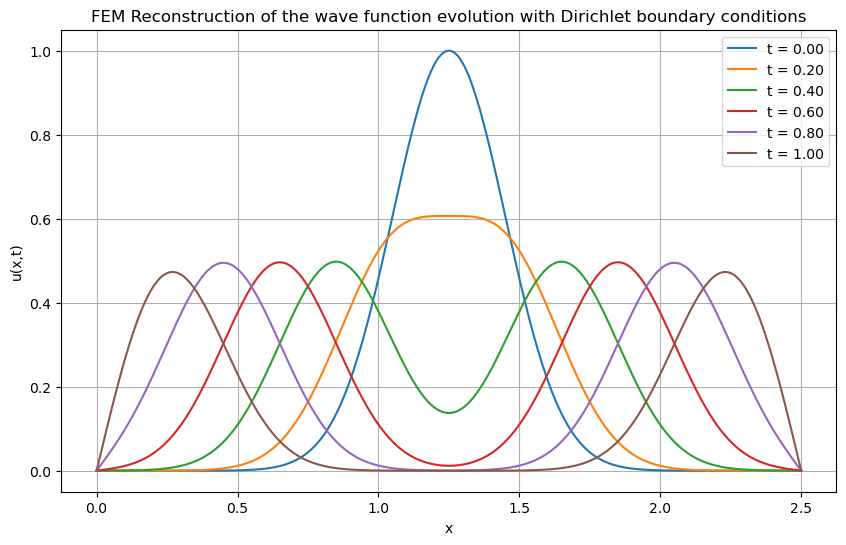

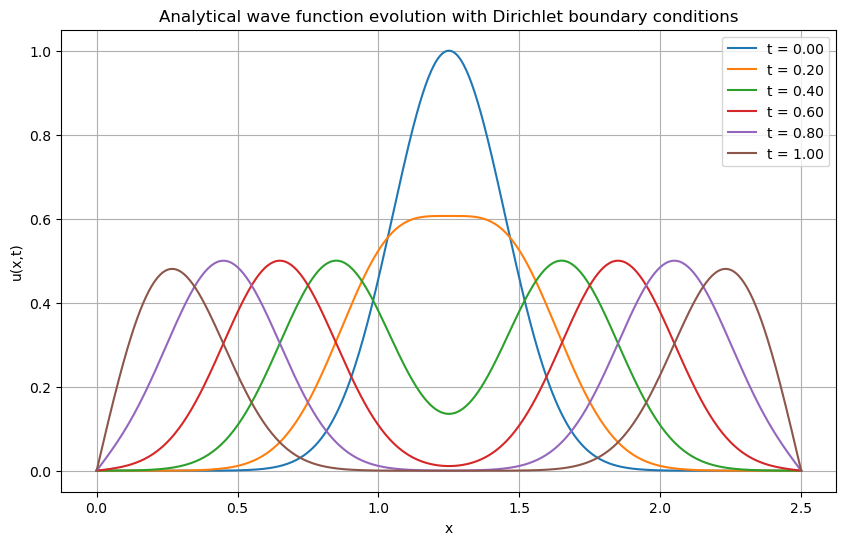

In [75]:
L  = 2.5
nx = 500
T  = 1.0
dt = 0.001
c  = 1.0
bc = "Dirichlet"

classical_wave_function(L = L, nx = nx, T = T, dt = dt, c = c, f = lambda x: gaussian(x, x0 = L/2, sigma = 0.2), bc = bc, n_plots = 6)
classica_wave_function_analytical(L = L, nx = nx, T = T, c = c, f = lambda x: gaussian(x, x0 = L/2, sigma = 0.2), N_modes = 50, bc = bc, n_plots = 6)